In [1]:
import os
print (os.getcwd())

/home/cpu/git/cpu/study/diploma/code


In [2]:

# Find differences between files pipeline
from pipeline_clean import CleanPipeline
cpp = CleanPipeline()
cpp.process()
cpp.maping

2025-01-12 02:46:29.379179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 02:46:29.380258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 02:46:29.382998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 02:46:29.391254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736642789.406358   34982 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736642789.41

{'data/Воспл. 4500355000-01 № 095/2014_04_03 Воспл. 4500355000-01 № 095/2/protA3.rtf': 'В воздухоподводящем отверстии установлено 9 проволок: из,них 8 штук d=1,5 мм., и 1 штука d=1мм.',
 'data/Воспл. 4500355000-01 № 095/2014_04_03 Воспл. 4500355000-01 № 095/1/protA3.rtf': 'В воздухоподводящем отверстии установлено 10 проволок: из,них 9 штук d=1,5 мм., и 1 штука d=1мм.',
 'data/Воспл. 4500355000-01 № 095/2014_04_07 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 9 проволоктd=1,5,мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_25 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 5 проволоки,d=1,5 мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_31 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 10 проволок,d=1,5 мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_20 Воспл. 4500355000-01 № 095/2/protA3.rtf': 'В воздухоподводящем отверстии установлено 4 проволоки,d=1,5 мм.',
 'data/Воспл. 4500

In [ ]:
from pipeline_data import DataPipeline
from abstracts import ModelContext
from constants import MODEL_CLASSES

ppl = DataPipeline()
ppl.load()
ppl.split()
print (len(ppl.train_data))

ctx = ModelContext(classes=MODEL_CLASSES, train_data=ppl.train_data, val_data=ppl.val_data)
ctx.restore()

246


/home/cpu/git/cpu/study/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


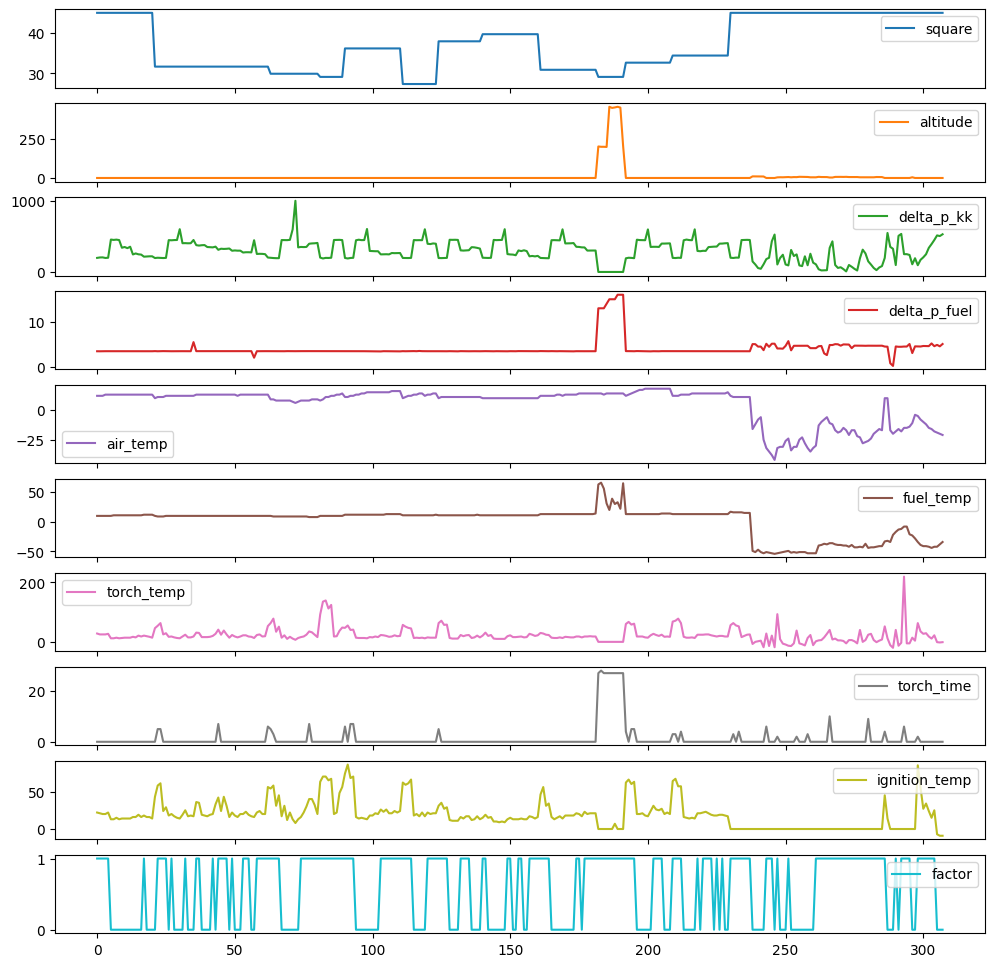

In [6]:
from matplotlib import pyplot
import pandas
data_frame = pandas.DataFrame(ppl.raw_data)
plot_data_frame = data_frame[data_frame.columns]
_ = plot_data_frame.plot(subplots=True, figsize=(12, 12), legend=True)
pyplot.savefig('dataset.png')

In [ ]:
import seaborn
correlation_with_factor = data_frame.corr()['factor'].drop('factor')
correlation_df = correlation_with_factor.to_frame(name='Кореляція').reset_index()
correlation_df.rename(columns={'index': 'Параметри'}, inplace=True)
pyplot.figure(figsize=(10, 3))  
ax = seaborn.heatmap(correlation_df.set_index('Параметри').T, annot=True,
                     cmap='coolwarm', fmt=".2f", cbar=True)
cbar = ax.collections[0].colorbar
cbar.set_label('Коеф. кореляції', rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
pyplot.tight_layout()
pyplot.savefig('corelation-heat-map.png')

In [ ]:
data_frame['factor'] = data_frame['factor'].astype('category')
seaborn.pairplot(data_frame, vars=['delta_p_kk', 'torch_temp', 'ignition_temp'], hue='factor', diag_kind='kde', palette='coolwarm')
pyplot.savefig('pair-plot.png')

In [ ]:
features = ppl.raw_data[0].keys()
linear_regression = ctx.strategies[0].model
print (linear_regression)
intercept = linear_regression.intercept_[0]  # Интерсепт
coefficients = linear_regression.coef_[0]
print("Полиномиальная модель:")
print(f"z = {intercept:.2f} " + " + ".join([f"{coeff:.2f}*{feature}" for coeff, feature in zip(coefficients, features)]))


In [ ]:
gaussian_naive = ctx.strategies[1].model
priors = gaussian_naive.class_prior_
theta = gaussian_naive.theta_
print (f'Априорные вероятности классов: {priors[0]:.2f} - горить, {priors[1]:.2f} - не горить')
print ('Средние значения признаков для класса - горить')
for coeff, feature in zip(gaussian_naive.theta_[0], features):
     print (f'{feature}: {coeff:.2f}')
print ('Средние значения признаков для класса - не горить')
for coeff, feature in zip(gaussian_naive.theta_[1], features):
     print (f'{feature}: {coeff:.2f}')


In [ ]:
result = dict()
for strategy in ctx.strategies:
    x = strategy.metrics
    row = {
        'accuracy': x['accuracy'],
        'precision': x['precision'],
        'recall': x['recall'],
        'f1': x['f1'],
        'roc_auc': x['roc_auc'],
        'mae': x['mae'],
    }
    if not x['overfit']:
        result[strategy.model_name] = (row)

import seaborn
import matplotlib.pyplot
import pandas
data_frame =pandas.DataFrame(result).T
df_melted = data_frame.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_melted.rename(columns={'index': 'Model'}, inplace=True)

pyplot.figure(figsize=(12, 8))
seaborn.lineplot(data=df_melted, x='Model', y='Value', hue='Metric', marker='o', linewidth=2)

pyplot.ylabel('Значення', fontsize=14)
pyplot.xlabel('Модель', fontsize=14)
pyplot.xticks(rotation=45, ha='right', fontsize=12)
pyplot.ylim(0, 1.1)
pyplot.grid(axis='y', linestyle='--', alpha=0.7)
pyplot.legend(title='Метрика', fontsize=12, loc='upper left')
pyplot.tight_layout()
pyplot.savefig('mtrics-plot.png')

In [ ]:
strategy = ctx.strategies[0]
model = strategy.model
raise Exception()

import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Обучение классификатора (Random Forest для предсказания вероятностей)

model.fit(X, y)
# Прогнозирование вероятностей класса 0
probabilities = model.predict_proba(X)[:, 0]

# PCA: уменьшение размерности до 2D

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE: уменьшение размерности до 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Визуализация результатов PCA
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=probabilities, cmap="coolwarm", alpha=0.7, edgecolor="k")
plt.colorbar(label="Вероятность отсутствия класса (class=0)")
plt.title("PCA-визуализация данных")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Визуализация результатов t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=probabilities, cmap="coolwarm", alpha=0.7, edgecolor="k")
plt.colorbar(label="Вероятность отсутствия класса (class=0)")
plt.title("t-SNE-визуализация данных")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")


plt.tight_layout()
plt.show()